# Predict Future Sales

kaggle link : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

Second part of feauture enginering and ML modeling - testing advanced models and advanced features

issues:
* check the unexepected high variations
* check when 0 and when sth
* check the high number of 0
those are big portion of the targets

kaggle link : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns; sns.set()
from dateutil.relativedelta import relativedelta

import plotly.express as px

In [2]:
from my_functions import merge_basic, convert_silver, completion_semi_gold, scaler, inversed_scale, consolidation_prediction, plot_prediction, preparing_to_predict, plot_metrics

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

In [4]:
from sklearn.preprocessing import LabelEncoder

### Data

In [5]:
daily_train = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
categories = pd.read_csv('item_categories.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

### Data modeling

In [6]:
def cleaning_shop_categs():
    shops[['comp1','comp2']] = shops.shop_name.str.split(' "',expand=True,)
    shops['comp1'] = shops.comp1.replace({r'\([^)]*\)' : ''}, regex=True)
    shops['comp1'] = shops['comp1'].str.split(' ').str[0]

    shops['comp2'] = shops.comp2.replace({r'\([^)]*\)' : ''}, regex=True)
    shops['comp2'] = shops.comp2.replace({'"' :''}, regex=True)

    categories[['comp1','comp2']] = categories.item_category_name.str.split(" - ",expand=True,)
    categories['comp1'] = categories.comp1.replace({r'\([^)]*\)' : ''}, regex=True)
    categories['comp2'] = categories.comp2.replace({r'\([^)]*\)' : ''}, regex=True)
    
    return shops, categories

In [7]:
def indexing_shop_categs(data, column,prefix):
    my_map = dict()
    for index, value in enumerate(data[column].unique()):
        my_map[value] = index
    data[f'map_{column}{prefix}'] = data[column].map(my_map)
    return data

In [8]:
shops, categories = cleaning_shop_categs()
shops = indexing_shop_categs(shops, 'comp1', 'shop')
shops = indexing_shop_categs(shops, 'comp2', 'shop')
categories = indexing_shop_categs(categories, 'comp1', 'categ')
categories = indexing_shop_categs(categories, 'comp2', 'categ')

In [9]:
train_merge = merge_basic(daily_train, test, 'left')

In [10]:
wholedata_silver = convert_silver(train_merge)

In [11]:
wholedata_silver.head()

,SaleDateMY,date_block_num,shop_id,item_id,item_name,item_category_id,shop_name,item_category_name,map_comp1categ,map_comp2categ,map_comp1shop,map_comp2shop,InTest,item_cnt_day,item_price,shopitem
0,2013-01-01,0,0,32,1+1,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,11,22,0,0,0,6.0,221.0,0-32
1,2013-01-01,0,0,33,1+1 (BD),37,"!Якутск Орджоникидзе, 56 фран",Кино - Blu-Ray,11,19,0,0,0,3.0,347.0,0-33
2,2013-01-01,0,0,35,10 ЛЕТ СПУСТЯ,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,11,22,0,0,0,1.0,247.0,0-35
3,2013-01-01,0,0,43,100 МИЛЛИОНОВ ЕВРО,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,11,22,0,0,0,1.0,221.0,0-43
4,2013-01-01,0,0,51,100 лучших произведений классики (mp3-CD) (Dig...,57,"!Якутск Орджоникидзе, 56 фран",Музыка - MP3,13,38,0,0,0,2.0,130.0,0-51


<b> Splitting strategy:

* time series expanding window of one period, Take 7 months
* over the first fold, make the functions and features for modeling and prediction (avoid leakage)
* lags and seasons are features
* use rmse as metric
* consider the outputs of the EDA
* goal, predict november or yyyy-11-01

#### The validation data

In [12]:
wholedata_silver.SaleDateMY.max()

Timestamp('2015-10-01 00:00:00')

In [13]:
test_dates = [datetime.datetime(2014, 11, 1), datetime.datetime(2015, 4, 1), datetime.datetime(2015, 5, 1), datetime.datetime(2015, 6, 1), datetime.datetime(2015, 7, 1), datetime.datetime(2015, 8, 1),
datetime.datetime(2015, 9, 1), datetime.datetime(2015, 10, 1),]

In [14]:
whole_test_data = wholedata_silver[wholedata_silver.SaleDateMY.isin(test_dates)][['SaleDateMY','date_block_num','shop_id','item_id','item_cnt_day']]

#### hold-out Train

In [15]:
date_val = datetime.datetime(2015, 1, 1)

In [16]:
train_window = wholedata_silver[wholedata_silver.SaleDateMY < date_val ].copy()
val_window = wholedata_silver[wholedata_silver.SaleDateMY == date_val ][['SaleDateMY','shop_id','item_id','item_cnt_day']].copy()

In [17]:
train_window.head()

,SaleDateMY,date_block_num,shop_id,item_id,item_name,item_category_id,shop_name,item_category_name,map_comp1categ,map_comp2categ,map_comp1shop,map_comp2shop,InTest,item_cnt_day,item_price,shopitem
0,2013-01-01,0,0,32,1+1,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,11,22,0,0,0,6.0,221.0,0-32
1,2013-01-01,0,0,33,1+1 (BD),37,"!Якутск Орджоникидзе, 56 фран",Кино - Blu-Ray,11,19,0,0,0,3.0,347.0,0-33
2,2013-01-01,0,0,35,10 ЛЕТ СПУСТЯ,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,11,22,0,0,0,1.0,247.0,0-35
3,2013-01-01,0,0,43,100 МИЛЛИОНОВ ЕВРО,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,11,22,0,0,0,1.0,221.0,0-43
4,2013-01-01,0,0,51,100 лучших произведений классики (mp3-CD) (Dig...,57,"!Якутск Орджоникидзе, 56 фран",Музыка - MP3,13,38,0,0,0,2.0,130.0,0-51


In [18]:
train_window.SaleDateMY.max(), train_window.SaleDateMY.min()

(Timestamp('2014-12-01 00:00:00'), Timestamp('2013-01-01 00:00:00'))

In [19]:
train_full = completion_semi_gold(train_window)

In [20]:
train_full.head()

,InTest,shop_id,item_id,item_name,shopitem,item_category_id,shop_name,item_category_name,map_comp1categ,map_comp2categ,map_comp1shop,map_comp2shop,Date,Sale,item_price,Order,MiguelId
0,0,0,30,007: КООРДИНАТЫ «СКАЙФОЛЛ»,0-30,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,11,22,0,0,2013-01-01,0.0,0.0,1,0-30-2013-01-01
1,0,0,31,007: КООРДИНАТЫ «СКАЙФОЛЛ» (BD),0-31,37,"!Якутск Орджоникидзе, 56 фран",Кино - Blu-Ray,11,19,0,0,2013-01-01,0.0,0.0,1,0-31-2013-01-01
2,0,0,32,1+1,0-32,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,11,22,0,0,2013-01-01,6.0,221.0,1,0-32-2013-01-01
3,0,0,33,1+1 (BD),0-33,37,"!Якутск Орджоникидзе, 56 фран",Кино - Blu-Ray,11,19,0,0,2013-01-01,3.0,347.0,1,0-33-2013-01-01
4,0,0,35,10 ЛЕТ СПУСТЯ,0-35,40,"!Якутск Орджоникидзе, 56 фран",Кино - DVD,11,22,0,0,2013-01-01,1.0,247.0,1,0-35-2013-01-01


In [21]:
train_full.shape

(8825904, 17)

In [22]:
train_full.Sale.max()

20.0

### explo cateogries

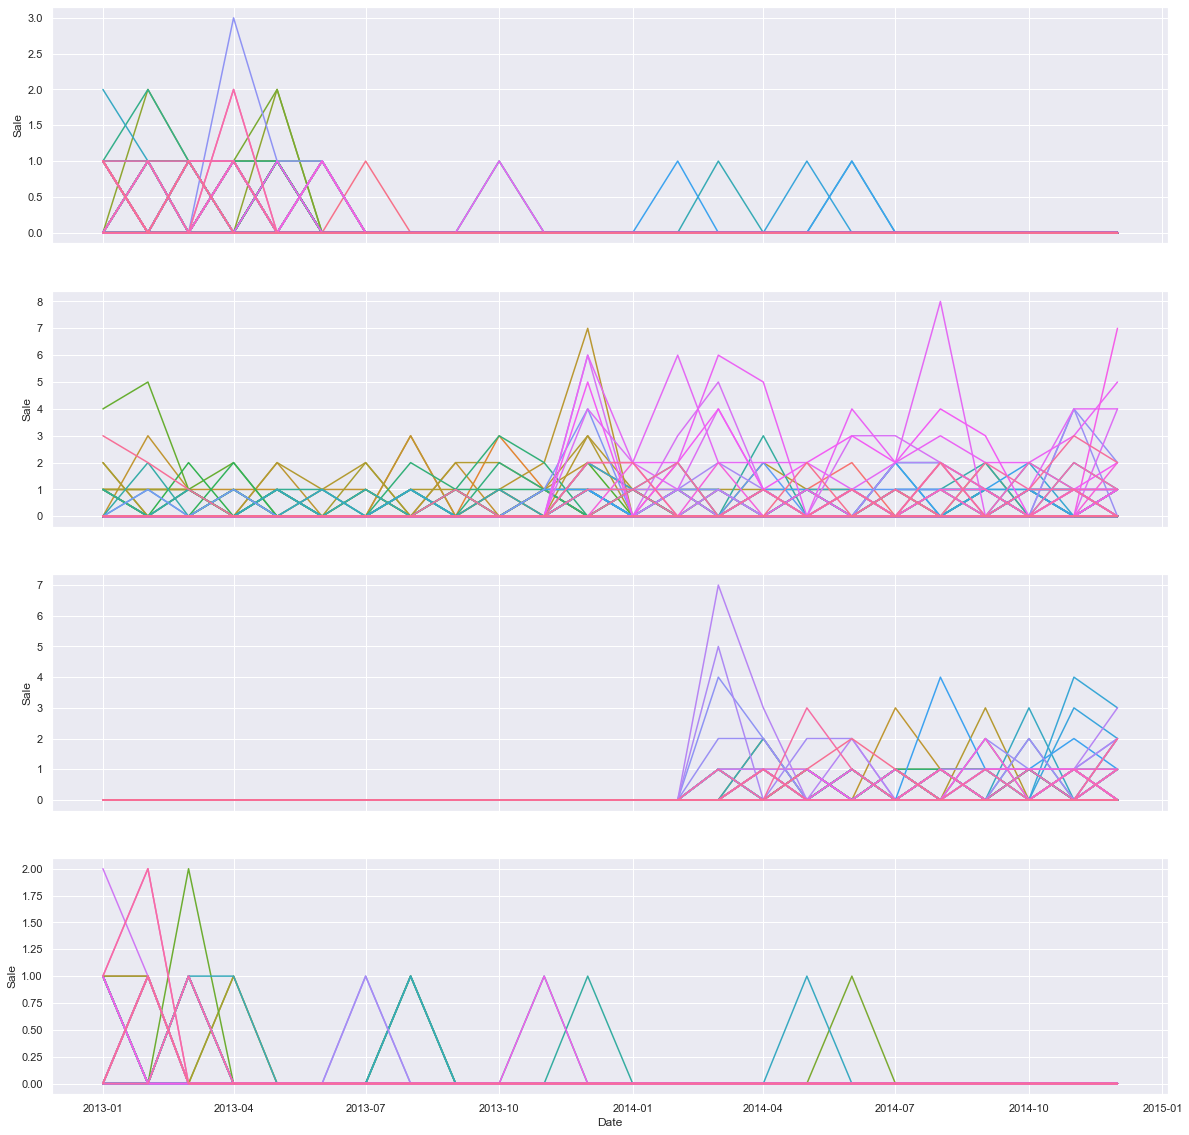

In [23]:
fig, axs = plt.subplots(nrows=4, ncols=1,figsize=(20,20), sharex=True)
ax = sns.lineplot(ax = axs[0] , data = train_full[(train_full.map_comp1categ == 13) & (train_full.map_comp2categ == 40) &
                                                  (train_full.map_comp1shop == 17) & (train_full.map_comp2shop == 2)] , x="Date", y="Sale", hue = 'shopitem' )
ax = sns.lineplot(ax = axs[1] , data = train_full[(train_full.map_comp1categ == 14) & (train_full.map_comp2categ == 53) &
                                                  (train_full.map_comp1shop == 10) & (train_full.map_comp2shop == 10)] , x="Date", y="Sale", hue = 'shopitem' )
ax = sns.lineplot(ax = axs[2] , data = train_full[(train_full.map_comp1categ == 14) & (train_full.map_comp2categ == 53) &
                                                  (train_full.map_comp1shop == 19) & (train_full.map_comp2shop == 30)] , x="Date", y="Sale", hue = 'shopitem' )
ax = sns.lineplot(ax = axs[3] , data = train_full[(train_full.map_comp1categ == 13) & (train_full.map_comp2categ == 40) &
                                                  (train_full.map_comp1shop == 3) & (train_full.map_comp2shop == 4)] , x="Date", y="Sale", hue = 'shopitem' )
axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[2].get_legend().remove()
axs[3].get_legend().remove()
#plt.xlim(train_full.Date.min() - relativedelta(months=1), train_full.Date.max() + relativedelta(months=1) )

In [24]:
def q1(x):
    return x.quantile(0.25)

def q2(x):
    return x.quantile(0.50)

def q3(x):
    return x.quantile(0.90)

df_explot = train_full[train_full.Date == datetime.datetime(2014,6,1)]\
    .groupby(['map_comp1categ','map_comp2categ','map_comp1shop','map_comp2shop','Date'])\
    .agg(shopitems = ('shopitem','nunique'),
        q1 = ('Sale', q1),
        q2 = ('Sale', q2),
        q3 = ('Sale', q3),
        Max = ('Sale', 'max'),
        )
df_explot = df_explot.sort_values('Max',ascending = True).reset_index().reset_index()

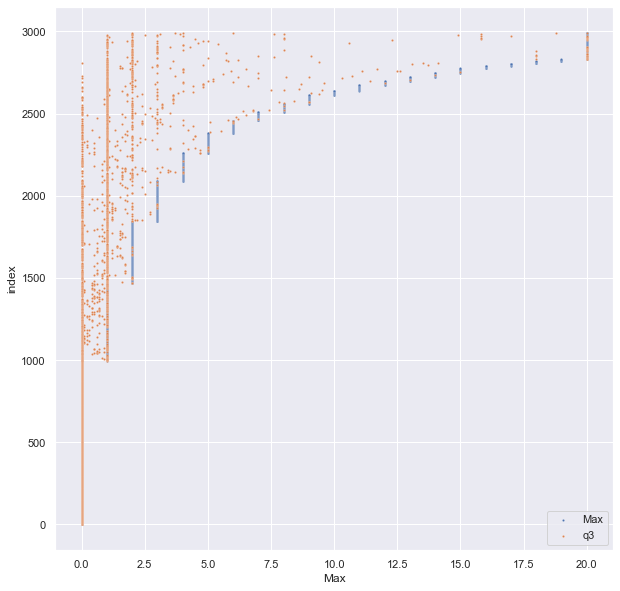

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(10,10), sharex=True)
ax = sns.scatterplot(ax = axs , data = df_explot , x="Max", y="index", s = 5 , label = "Max")
ax = sns.scatterplot(ax = axs , data = df_explot , x="q3", y="index", s = 5, label = "q3" )
ax.legend()

In [26]:
train_full['itemMax'] = train_full.groupby(['shopitem']).Sale.transform('max').copy()
train_full['itemMin'] = train_full.groupby(['shopitem']).Sale.transform('min')
train_full['SaleScaled'] = ((train_full.Sale - train_full.itemMin)/(train_full.itemMax - train_full.itemMin))

In [27]:
df_plot = train_full.groupby(['item_id','shop_id','map_comp1categ','map_comp2categ','map_comp1shop','map_comp2shop'
                                         ,'item_category_id','Order','itemMax','itemMin']).agg(SaleScaled = ('SaleScaled','max'),
                                                                                              Sale = ('Sale','max'),).reset_index()
df_plot['possnumb'] = np.where(df_plot.SaleScaled > 0 , 1,0)
df_plot['maxOrder'] = df_plot.groupby(['item_id','shop_id','possnumb']).cumcount() + 1
df_plot['maxOrder'] = np.where(df_plot.possnumb == 0 , 0, df_plot['maxOrder'] )
df_plot['OrderGot'] = np.where(df_plot.maxOrder == 1, df_plot.Order,0)
df_plot['OrderGot'] = df_plot.groupby(['item_id','shop_id']).OrderGot.transform('sum')
df_plot['possCounts'] = df_plot.groupby(['item_id','shop_id']).possnumb.transform('sum')

In [28]:
#'map_comp1categ','map_comp2categ','map_comp1shop','map_comp2shop'

In [29]:
df_plot_heat = df_plot.pivot_table(index= ['item_id','shop_id','itemMax','itemMin','map_comp1categ','map_comp2categ','map_comp1shop','map_comp2shop'
                                           ,'OrderGot','possCounts'],columns = 'Order' ,values = 'SaleScaled', aggfunc = 'sum')\
    .fillna(0)\
    .reset_index()\
    .sort_values(['OrderGot','possCounts'])
df_plot_heat['index'] = range(1,len(df_plot_heat) + 1)
df_plot_heat = df_plot_heat.set_index('index')

In [30]:
data_plot_mod = df_plot_heat.copy()
variable = 'shop_id'
random.seed(124)

data_plot_mod['Randomndex'] = random.shuffle(list(range(1, len(data_plot_mod) + 1 )) )
columns_wax = ['item_id','shop_id','itemMax','itemMin','map_comp1categ','map_comp2categ','map_comp1shop','map_comp2shop','Randomndex']
for colx in data_plot_mod.drop(columns = columns_wax).columns:
    data_plot_mod[colx] = np.where(data_plot_mod[colx] > 0, data_plot_mod[variable],0)
data_plot_mod = data_plot_mod[data_plot_mod.itemMax < 3].drop(columns = columns_wax + ['OrderGot','possCounts'])

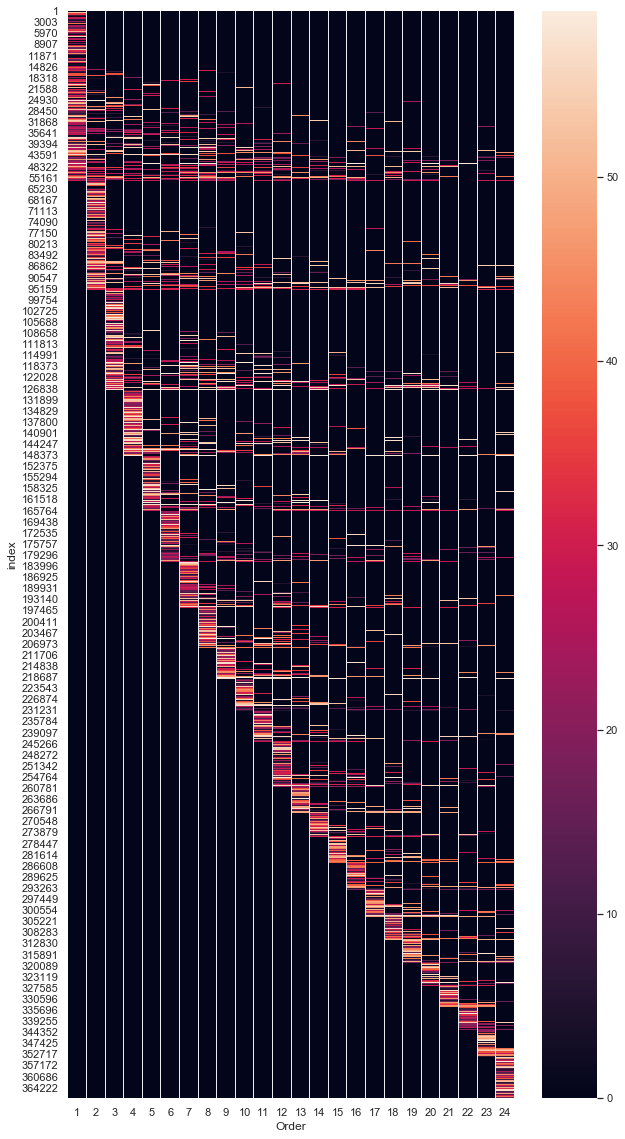

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,20), sharex=True)
ax = sns.heatmap(data_plot_mod)

* The index I created with the item ID is a strong feature
* at the beginning small numbers, at last high numbers more proportion

In [32]:
ploty = df_plot[df_plot.itemMax > 3].groupby(['item_id','Order'])\
    .agg(Sale = ('Sale','max'))\
    .reset_index()\
    .pivot_table(index = 'item_id', columns = 'Order', values = 'Sale', aggfunc = 'median')

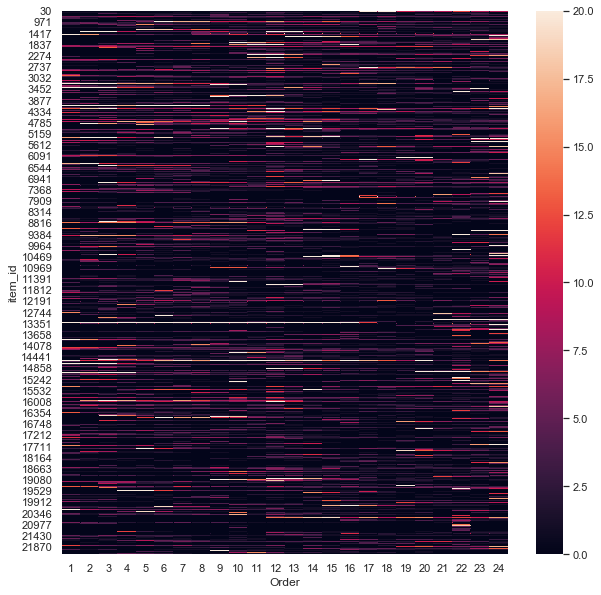

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10), sharex=True)
ax = sns.heatmap(ploty)

In [23]:
train_full.Date.max()

Timestamp('2014-12-01 00:00:00')

In [36]:
train_full.columns

Index(['InTest', 'shop_id', 'item_id', 'item_name', 'shopitem',
       'item_category_id', 'shop_name', 'item_category_name', 'map_comp1categ',
       'map_comp2categ', 'map_comp1shop', 'map_comp2shop', 'Date', 'Sale',
       'item_price', 'Order', 'MiguelId'],
      dtype='object')

In [48]:
df_plot = train_full[train_full.Date.isin([train_full.Date.max(), train_full.Date.max() - relativedelta(months = 1)])]\
    [['shop_id','item_id','shopitem','Date','Order','Sale']]
df_plot = df_plot[df_plot.Sale > 2 ]\
    .pivot_table(index = ['shop_id','item_id','shopitem'], columns = 'Order', values = 'Sale', aggfunc = 'sum').reset_index()
df_plot = df_plot.pivot_table(index = 23, columns = 24, values = 'shopitem', aggfunc = 'count')

In [49]:
df_plot.head()

24,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
23,,,,,,,,,,,,,,,,,,
3.0,401.0,266.0,175.0,124.0,91.0,63.0,53.0,36.0,27.0,21.0,14.0,8.0,5.0,3.0,4.0,10.0,2.0,20.0
4.0,196.0,159.0,129.0,82.0,69.0,56.0,39.0,33.0,20.0,18.0,15.0,8.0,5.0,6.0,2.0,4.0,1.0,16.0
5.0,92.0,86.0,68.0,77.0,52.0,45.0,25.0,26.0,16.0,23.0,8.0,8.0,10.0,9.0,8.0,4.0,1.0,25.0
6.0,61.0,58.0,61.0,48.0,35.0,38.0,26.0,22.0,16.0,14.0,10.0,9.0,6.0,7.0,3.0,2.0,6.0,16.0
7.0,35.0,40.0,25.0,37.0,33.0,22.0,20.0,19.0,9.0,7.0,6.0,14.0,3.0,2.0,7.0,1.0,5.0,26.0


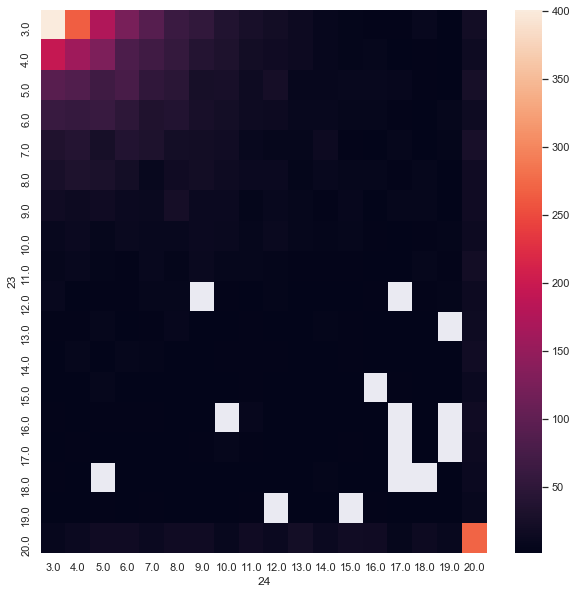

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10), sharex=True)
ax = sns.heatmap(df_plot)

In [187]:
df_feature = train_full[train_full.Order >= train_full.Order.max() - 5]\
    [['shop_id','item_id','shopitem','Date','Order','Sale']]
df_feature['OrderGo'] = df_feature['Order'] - df_feature['Order'].min()
df_feature = df_feature[df_feature.Sale > 2 ]  #optional

In [189]:
df_feature['SaleL1M'] = df_feature.sort_values('Date').groupby(['shopitem'])['Sale'].shift(1)
df_feature = df_feature.assign(L0M_L1M = df_feature.Sale - df_feature.SaleL1M)  ### This is new target ???? but yeaaaaaHHH

In [191]:
df_feature.head()

,shop_id,item_id,shopitem,Date,Order,Sale,OrderGo,SaleL1M,L0M_L1M
6625588,2,984,2-984,2014-07-01,19,3.0,0,NaN,NaN
6625699,2,1825,2-1825,2014-07-01,19,3.0,0,NaN,NaN
6625700,2,1826,2-1826,2014-07-01,19,19.0,0,NaN,NaN
6625711,2,1855,2-1855,2014-07-01,19,4.0,0,NaN,NaN
6625859,2,2766,2-2766,2014-07-01,19,20.0,0,NaN,NaN


one feature is the lagged mean item L0_l1M 

another the M-3 mean lagged

In [198]:
df_feature.groupby(['item_id','Date']).agg(meanLaggedVars = ('L0M_L1M','mean')).reset_index()

,item_id,Date,meanLaggedVars
0,30,2014-08-01,NaN
1,30,2014-10-01,NaN
2,30,2014-11-01,NaN
3,30,2014-12-01,1.000000
4,31,2014-07-01,NaN
...,...,...,...
10045,22167,2014-08-01,2.000000
10046,22167,2014-09-01,-2.333333
10047,22167,2014-10-01,1.666667
10048,22167,2014-11-01,1.250000


In [201]:
df_feature[df_feature.OrderGo >= 3].fillna(0).groupby(['item_id']).agg(meanLastLagsVars = ('L0M_L1M','mean')).reset_index()

,item_id,meanLastLagsVars
0,30,0.400000
1,31,0.000000
2,32,1.000000
3,33,0.000000
4,45,0.000000
...,...,...
3116,22092,0.656250
3117,22111,0.000000
3118,22118,0.000000
3119,22166,-0.666667


### clustering and cluster frequency

In [34]:
df_plot['SpaceOrder'] = df_plot['Order'] - df_plot['OrderGot']
df_plot_select = df_plot[df_plot['SpaceOrder'] >= 0 ].copy()

In [35]:
df_plot_heat = df_plot_select.pivot_table(index= ['item_id','shop_id','itemMax','itemMin','map_comp1categ','map_comp2categ','map_comp1shop','map_comp2shop'
                                           ,'OrderGot','possCounts'],columns = 'SpaceOrder' ,values = 'SaleScaled', aggfunc = 'sum')\
    .fillna(0)\
    .reset_index()\
    .sort_values(['possCounts'])
df_plot_heat['index'] = range(1,len(df_plot_heat) + 1)
df_plot_heat = df_plot_heat.set_index('index')

In [36]:
data_plot_mod = df_plot_heat.copy()
variable = 'shop_id'
random.seed(124)

data_plot_mod['Randomndex'] = random.shuffle(list(range(1, len(data_plot_mod) + 1 )) )
columns_wax = ['item_id','shop_id','itemMax','itemMin','map_comp1categ','map_comp2categ','map_comp1shop','map_comp2shop','Randomndex','OrderGot']
for colx in data_plot_mod.drop(columns = columns_wax).columns:
    data_plot_mod[colx] = np.where(data_plot_mod[colx] > 0, data_plot_mod[variable],0)
data_plot_mod = data_plot_mod.drop(columns = columns_wax + ['possCounts'])

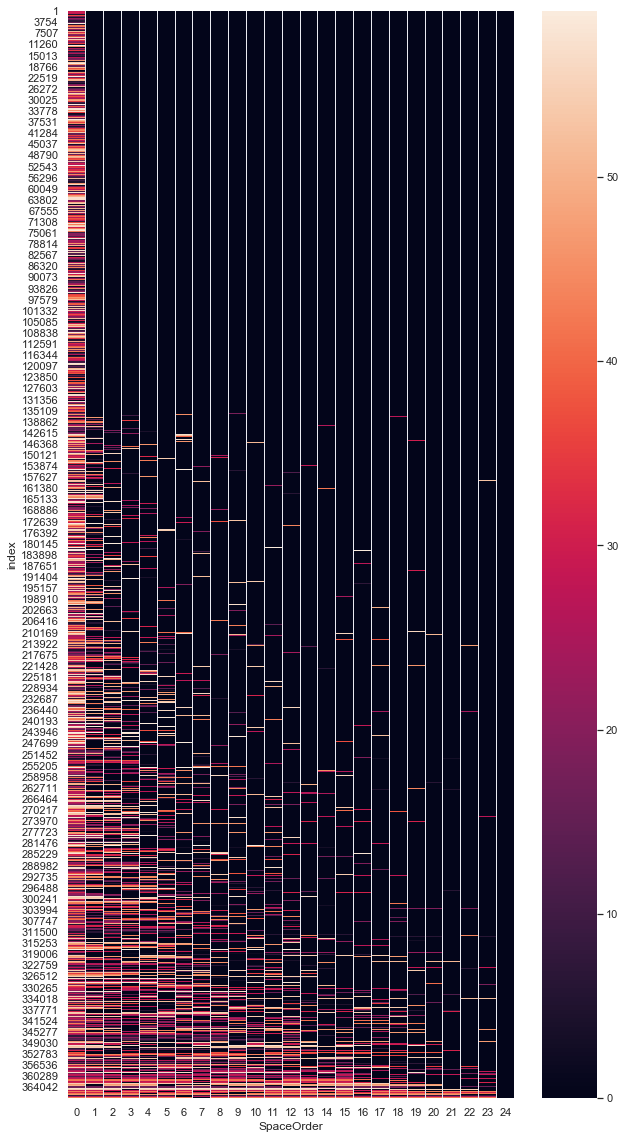

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,20), sharex=True)
ax = sns.heatmap(data_plot_mod)

<b> clustering

In [22]:
data = train_full.copy()
data['itemShopMax'] = data.groupby(['shopitem']).Sale.transform('max')
data['possnumb'] = np.where(data.Sale > 0 , 1,0)
data['possCounts'] = data.groupby(['item_id','shop_id']).possnumb.transform('sum')
data['maxOrder'] = data.groupby(['item_id','possnumb']).cumcount() + 1
data['maxOrder'] = np.where(data.possnumb == 0 , 0, data['maxOrder'] )
data['OrderGot'] = np.where(data.maxOrder == 1, data.Order,0)
data['OrderGot'] = data.groupby(['item_id']).OrderGot.transform('sum')
data['SpaceOrder'] = data['Order'] - data['OrderGot']
data = data[data['SpaceOrder'] >= 0 ].copy()

In [23]:
data_horizontal = data.pivot_table(index= ['item_id','shop_id','map_comp1categ','map_comp2categ','map_comp1shop','map_comp2shop'
                                           ,'OrderGot','possCounts'],columns = 'SpaceOrder' ,values = 'Sale', aggfunc = 'sum')\
    .fillna(0)\
    .reset_index()\
    .sort_values(['possCounts'])
data_horizontal['index'] = range(1,len(data_horizontal) + 1)
data_horizontal = data_horizontal.set_index('index')

In [27]:
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
import scipy

In [25]:
data_horizontal.iloc[:,10:-1].shape

(367746, 22)

In [30]:
train_x = data_horizontal.iloc[:,10:-1]
sparse_train = scipy.sparse.csr_matrix(data_horizontal.iloc[:,10:-1].astype(float).values)

In [34]:
train_x

SpaceOrder,2,3,4,5,6,7,8,9,10,11,...,14,15,16,17,18,19,20,21,22,23
index,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367742,5.0,6.0,6.0,11.0,8.0,10.0,5.0,6.0,7.0,5.0,...,10.0,1.0,1.0,3.0,1.0,5.0,12.0,2.0,2.0,3.0
367743,2.0,1.0,3.0,3.0,3.0,4.0,3.0,2.0,4.0,6.0,...,1.0,2.0,1.0,1.0,2.0,3.0,1.0,3.0,1.0,5.0
367744,2.0,2.0,1.0,4.0,6.0,4.0,4.0,2.0,6.0,6.0,...,4.0,5.0,2.0,2.0,4.0,1.0,2.0,3.0,4.0,1.0


In [31]:
%%time
kmeans = KMeans( n_clusters = 15).fit(train_x)

Wall time: 44.3 s


In [32]:
%%time
sparse_kmeans = KMeans( n_clusters = 15).fit(sparse_train)

Wall time: 2min 23s


In [27]:
kmeans.labels_.shape, data_horizontal.shape

((367746,), (367746, 33))

In [28]:
data_horizontal['Cluster'] = kmeans.labels_ + 1 

In [29]:
data_cluster = data_horizontal[['item_id','shop_id','map_comp1categ','map_comp2categ','map_comp1shop','map_comp2shop','Cluster']].copy()

In [30]:
data_cluster.head()

SpaceOrder,item_id,shop_id,map_comp1categ,map_comp2categ,map_comp1shop,map_comp2shop,Cluster
index,,,,,,,
1,7568,37,13,37,17,2,14
2,4580,37,13,39,17,2,14
3,293,44,12,27,21,34,14
4,5662,16,1,3,11,11,14
5,13419,44,8,12,21,34,14


In [31]:
cluster_item = data_cluster.groupby(['item_id','Cluster']).agg(count = ('map_comp2shop','count')).reset_index()
cluster_item['orderCluster'] = cluster_item.groupby(['item_id'])['count'].rank("dense", ascending=False)

In [32]:
cluster_item[cluster_item.item_id == 22167]

,item_id,Cluster,count,orderCluster
21790,22167,1,7,2.0
21791,22167,6,1,3.0
21792,22167,14,40,1.0


In [33]:
variable = 'item_id'
get_order = 5

cluster_item = data_cluster.groupby([variable,'Cluster']).agg(count = ('map_comp2shop','count')).reset_index()
cluster_item['orderCluster'] = cluster_item.groupby([variable])['count'].rank("dense", ascending=False)

vector = cluster_item.groupby(variable).agg(countClusters = ('Cluster','nunique')).reset_index()

for i in range(1,get_order+1):
    cluster_i = cluster_item[cluster_item.orderCluster == i][[variable,'Cluster']].rename(columns = {'Cluster':f'{variable}ClusterOrder{i}'}).copy()
    vector = vector.merge(cluster_i, on = variable, how = 'left')
    if i > 1:
        j = i - 1
        vector[f'{variable}ClusterOrder{i}'] = np.where(vector[f'{variable}ClusterOrder{i}'].isnull(),vector[f'{variable}ClusterOrder{j}'],
                                                   vector[f'{variable}ClusterOrder{i}'] )

In [34]:
train_full_cluster = train_full.merge(vector, on = variable, how = 'left').copy()

In [38]:
dfgg = train_full_cluster.groupby(['item_id','shop_id','item_idClusterOrder1'])[['Sale']].count().reset_index()

In [40]:
dfgg.item_idClusterOrder1.unique()

array([14,  3,  1,  6, 15,  4,  7,  8], dtype=int64)

In [42]:
dfgg[dfgg.item_idClusterOrder1 == 6]

,item_id,shop_id,item_idClusterOrder1,Sale
4603,798,55,6,24
4628,803,55,6,24
4669,805,55,6,24
20703,1830,0,6,24
20704,1830,1,6,24
...,...,...,...,...
277659,16832,18,6,24
277661,16832,21,6,24
277663,16832,25,6,24
355017,21486,55,6,24


In [79]:
train_full_cluster.columns

Index(['InTest', 'shop_id', 'item_id', 'shopitem', 'item_category_id',
       'shop_name', 'item_category_name', 'map_comp1categ', 'map_comp2categ',
       'map_comp1shop', 'map_comp2shop', 'Date', 'Sale', 'Order', 'MiguelId',
       'itemMax', 'itemMin', 'SaleScaled', 'countClusters',
       'item_idClusterOrder1', 'item_idClusterOrder2', 'item_idClusterOrder3',
       'item_idClusterOrder4', 'item_idClusterOrder5'],
      dtype='object')

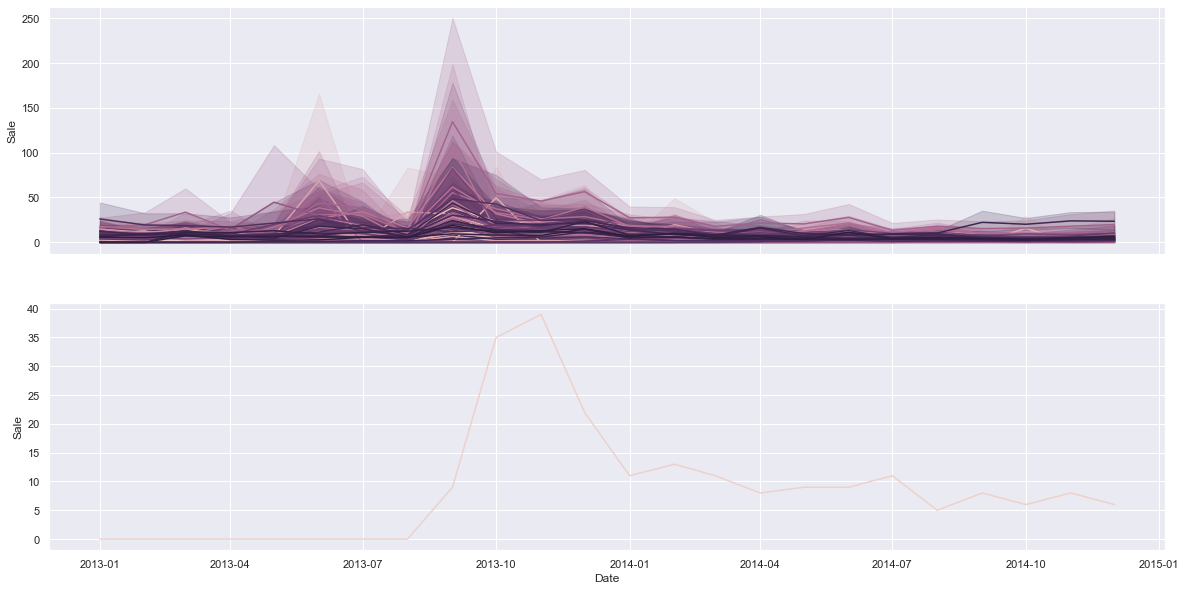

In [45]:
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(20,10), sharex=True)
ax = sns.lineplot(ax = axs[0] , data = train_full_cluster[train_full_cluster.item_idClusterOrder1 == 6] , x="Date", y="Sale", hue = 'shop_id' )
ax = sns.lineplot(ax = axs[1] , data = train_full_cluster[(train_full_cluster.item_id == 803) & (train_full_cluster.shop_id == 55)] , x="Date", y="Sale", hue = 'shop_id' )

axs[0].get_legend().remove()
axs[1].get_legend().remove()

### Last month/date and order Sale

shop - item last sale

In [46]:
groupy = train_full.groupby(['shop_id','item_id'])[['Sale']].count()
len(groupy), len(test), len(test.merge(groupy, on = ['shop_id','item_id'],how = 'inner'))

(367746, 214200, 72298)

In [47]:
ohla = ['item_id']
groupy = train_full.groupby(ohla)[['Sale']].count()
testi = test.assign(ones = 1).groupby(ohla)[['ones']].count()
len(groupy), len(testi), len(testi.merge(groupy, on = ohla,how = 'inner'))

(19047, 5100, 3140)

In [48]:
ohla = ['shop_id']
groupy = train_full.groupby(ohla)[['Sale']].count()
testi = test.assign(ones = 1).groupby(ohla)[['ones']].count()
len(groupy), len(testi), len(testi.merge(groupy, on = ohla,how = 'inner'))

(58, 42, 41)

In [49]:
df_feature = train_full[['shop_id','item_id','Order','Date','Sale']].copy()
df_feature['Month'] = train_full.Date.dt.month
df_feature['SaleFlag'] = np.where(df_feature['Sale'] > 0,1,0)
df_feature['LastOrder'] = df_feature.groupby(['shop_id','item_id','SaleFlag']).Order.transform('max')
df_feature['LastOrder'] = np.where(df_feature['SaleFlag'] == 1 , df_feature['LastOrder'], 0)
df_feature['LastOrder'] = df_feature.groupby(['shop_id','item_id']).LastOrder.transform('max')

df_feature['LastMonth'] = np.where(df_feature['LastOrder'] == df_feature['Order'], df_feature['Month'],0)
df_feature['LastMonth'] = df_feature.groupby(['shop_id','item_id']).LastMonth.transform('max')

In [50]:
df_feature[(df_feature.item_id == 30) & (df_feature.shop_id == 24)]

,shop_id,item_id,Order,Date,Sale,Month,SaleFlag,LastOrder,LastMonth
321388,24,30,1,2013-01-01,0.0,1,0,18,6
689134,24,30,2,2013-02-01,15.0,2,1,18,6
1056880,24,30,3,2013-03-01,8.0,3,1,18,6
1424626,24,30,4,2013-04-01,0.0,4,0,18,6
1792372,24,30,5,2013-05-01,2.0,5,1,18,6
2160118,24,30,6,2013-06-01,1.0,6,1,18,6
2527864,24,30,7,2013-07-01,1.0,7,1,18,6
2895610,24,30,8,2013-08-01,1.0,8,1,18,6
3263356,24,30,9,2013-09-01,1.0,9,1,18,6
3631102,24,30,10,2013-10-01,0.0,10,0,18,6


In [59]:
variable = 'item_id'
variable_y = 'LastMonth'

df_last = df_feature.groupby([variable,variable_y]).agg(count = ('Month','count')).reset_index()
df_last['orderCluster'] = df_last.groupby([variable])['count'].rank("dense", ascending=False)

vector = df_last.groupby(variable).agg(countClusters = (variable_y,'nunique')).reset_index()

for i in range(1,get_order+1):
    cluster_i = df_last[df_last.orderCluster == i][[variable,variable_y]].rename(columns = {variable_y:f'{variable}{variable_y}{i}'}).copy()
    vector = vector.merge(cluster_i, on = variable, how = 'left')
    if i > 1:
        j = i - 1
        vector[f'{variable}{variable_y}{i}'] = np.where(vector[f'{variable}{variable_y}{i}'].isnull(),vector[f'{variable}{variable_y}{j}'],
                                                   vector[f'{variable}{variable_y}{i}'] )

In [60]:
vector

,item_id,countClusters,item_idLastMonth1,item_idLastMonth2,item_idLastMonth3,item_idLastMonth4,item_idLastMonth5
0,0,1,9,9.0,9.0,9.0,9.0
1,1,1,10,10.0,10.0,10.0,10.0
2,2,1,11,11.0,11.0,11.0,11.0
3,3,1,8,8.0,8.0,8.0,8.0
4,4,1,9,9.0,9.0,9.0,9.0
...,...,...,...,...,...,...,...
136232,22167,8,12,11.0,9.0,10.0,8.0
136233,22168,4,2,1.0,1.0,1.0,1.0
136234,22168,4,2,3.0,3.0,3.0,3.0
136235,22168,4,2,9.0,9.0,9.0,9.0


### Prices

In [23]:
train_full.groupby('item_price').agg(sums = ('Sale','sum')).reset_index().sort_values('item_price',ascending = False).head(5)

,item_price,sums
7583,307980.0,1.0
7582,59200.0,20.0
7581,50999.0,1.0
7580,42000.0,1.0
7579,40900.0,1.0


In [24]:
df_plot_price = train_full[train_full.item_price > 0].groupby('item_id').agg(mini = ('item_price', 'min'),
                                  mean = ('item_price', 'mean'),
                                  maxi = ('item_price','max')).reset_index()
df_plot_price =  df_plot_price.melt(id_vars=['item_id'], value_vars=['mini','mean','maxi'], var_name='variable', value_name='value')

In [25]:
df_plot_price.head()

,item_id,variable,value
0,0,mini,58.0
1,1,mini,4490.0
2,2,mini,58.0
3,3,mini,58.0
4,4,mini,58.0


[None]

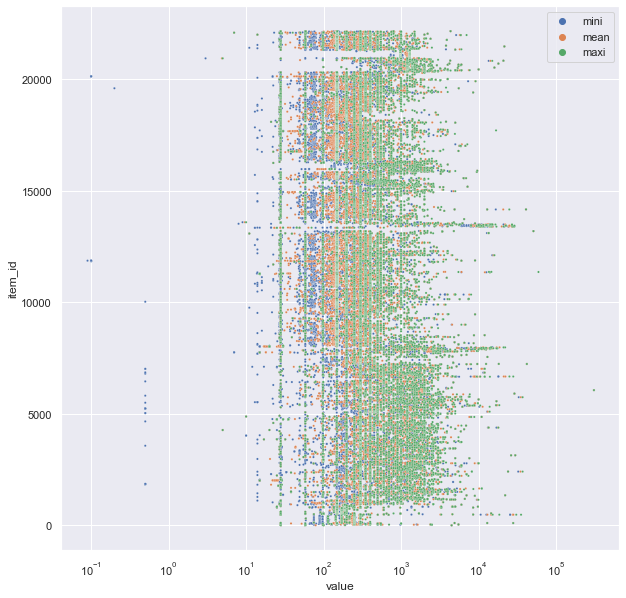

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(10,10), sharex=True)
ax = sns.scatterplot(ax = axs , data = df_plot_price , x="value", y="item_id", s = 5 , hue = "variable")
ax.legend()
ax.set(xscale="log")

In [27]:
df_feature = train_full[['shop_id','item_id','Date','Order','Sale','item_price']].copy()
df_feature['Sale'] = np.where(df_feature['Sale'] == 0, np.nan, df_feature['Sale'])
df_feature['avgPrice'] = df_feature.groupby(['item_id','Order']).item_price.transform('mean')
df_feature['L1Price'] = df_feature.sort_values('Date').groupby(['item_id','shop_id'])['item_price'].shift(1)

two features:
* lag
* positive sale lag

In [28]:
df_feature[(df_feature.item_id == 30) & (df_feature.shop_id == 24)]

,shop_id,item_id,Date,Order,Sale,item_price,avgPrice,L1Price
321388,24,30,2013-01-01,1,NaN,0.0,0.000,NaN
689134,24,30,2013-02-01,2,15.0,399.0,345.700,0.0
1056880,24,30,2013-03-01,3,8.0,399.0,334.300,399.0
1424626,24,30,2013-04-01,4,NaN,0.0,265.960,399.0
1792372,24,30,2013-05-01,5,2.0,399.0,154.240,0.0
2160118,24,30,2013-06-01,6,1.0,399.0,135.660,399.0
2527864,24,30,2013-07-01,7,1.0,399.0,178.178,399.0
2895610,24,30,2013-08-01,8,1.0,399.0,117.020,399.0
3263356,24,30,2013-09-01,9,1.0,399.0,79.800,399.0
3631102,24,30,2013-10-01,10,NaN,0.0,91.892,399.0


### Last inmediate average price

In [33]:
df_feature = train_full.copy()
df_feature['ItemMean'] = df_feature.groupby(['item_id','Date']).Sale.transform('mean')
df_feature = df_feature[['shop_id','item_id','Date','Sale','ItemMean']]

In [34]:
df_feature[(df_feature.shop_id == 59) & (df_feature.item_id == 22145)]

,shop_id,item_id,Date,Sale,ItemMean
367743,59,22145,2013-01-01,0.0,0.000000
735489,59,22145,2013-02-01,0.0,0.000000
1103235,59,22145,2013-03-01,0.0,0.000000
1470981,59,22145,2013-04-01,0.0,0.000000
1838727,59,22145,2013-05-01,0.0,0.000000
2206473,59,22145,2013-06-01,0.0,0.000000
2574219,59,22145,2013-07-01,0.0,0.000000
2941965,59,22145,2013-08-01,0.0,0.000000
3309711,59,22145,2013-09-01,0.0,0.000000
3677457,59,22145,2013-10-01,0.0,0.000000


### item name exploit

In [139]:
items_vector = list(train_full.item_name.unique())
items_vector = pd.DataFrame({'item_name': items_vector})

In [140]:
items_vector['lenstr'] = items_vector.item_name.str.len() ## this can be a feature
items_vector['NWords'] = items_vector.item_name.str.split().str.len()
items_vector['Word0'] = items_vector.item_name.str.split().str.get(0)
items_vector['Word_1'] = items_vector.item_name.str.split().str.get(-1)

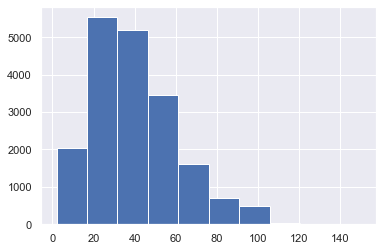

In [141]:
items_vector.lenstr.hist()

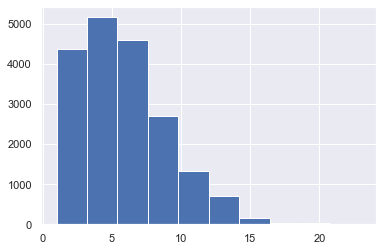

In [142]:
items_vector.NWords.hist()

In [143]:
items_vector.head()

,item_name,lenstr,NWords,Word0,Word_1
0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,26,3,007:,«СКАЙФОЛЛ»
1,007: КООРДИНАТЫ «СКАЙФОЛЛ» (BD),31,4,007:,(BD)
2,1+1,3,1,1+1,1+1
3,1+1 (BD),8,2,1+1,(BD)
4,10 ЛЕТ СПУСТЯ,13,3,10,СПУСТЯ


In [144]:
def my_tokengen(data, columnx):
    unique_words = list()
    for string in  list(data[columnx].values):
        for word in string.split():
            unique_words.append(word)
    unique_words = set(unique_words)
    unique_words = list(unique_words)
    unique_words.sort()
    number = [idx[0] +1 for idx in enumerate(unique_words)]
    map_word = {x:y for x,y in zip(unique_words, number)}

    data[columnx] = data[columnx].map(map_word)
    return data

In [145]:
items_vector = my_tokengen(items_vector, 'Word0')
items_vector = my_tokengen(items_vector, 'Word_1')

In [146]:
items_vector = items_vector.merge(items[['item_name','item_id']], on = 'item_name', how = 'left').drop(columns = 'item_name')

In [147]:
items_vector

,lenstr,NWords,Word0,Word_1,item_id
0,26,3,24,2059,30
1,31,4,24,200,31
2,3,1,25,475,32
3,8,2,25,200,33
4,13,3,26,3705,35
...,...,...,...,...,...
19042,36,5,4813,4261,21803
19043,62,8,4861,4261,21978
19044,41,5,4872,4261,21995
19045,47,5,4935,4261,22166
